# Resting Heart Rate Regression Model Using Fitbit data

## Navigation:
* [Introduction/motivation of project](#first-bullet)
* [Extract data and data exploration](#second-bullet)
* [First version of linear regression model](#third-bullet)
* [Improving the model](#fourth-bullet)
    * [Adding polynomial features](#fifth-bullet)
    * [Adding more features](#sixth-bullet)
* [Summary](#seventh-bullet)

## Introduction <a class="anchor" id="first-bullet"></a>

Resting heart rate (RHR) is a person's heart rate when they are physically inactive and mentally unstimulated (or resting). Often one's RHR thought to be a predictor of health, with typical values in the range of 50-90 beats per minute. 

Since RHR can be lowered by exercise and overall improving your health, I thought I would try to predict my RHR. Occasionally, I notice periods when my RHR is higher than others. This way I can know what I need to do to lower my RHR during these periods in the future. Do I need to spend more time working out? Or maybe I just need to get better quality sleep.

The aim of this project is to predict my RHR based on features having to do with the quality/duration of my sleep and my physical activity level. The target is my RHR. I will first train a linear regression model using this data.

## Extract Data and Data Exploration <a class="anchor" id="second-bullet"></a>

In [115]:
import os
import pandas as pd 
import numpy as np
import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt

First I'll quickly extract some sleep and exercise data

In [116]:
sleep_rhr_data = pd.read_csv(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Sleep/sleep_score.csv'))
sleep_rhr_data.loc[:,'timestamp']= pd.to_datetime(sleep_rhr_data.loc[:,'timestamp'])
sleep_rhr_data.loc[:,'timestamp'] = sleep_rhr_data.loc[:,'timestamp'].dt.date
sleep_rhr_data.drop('sleep_log_entry_id', axis = 1, inplace = True)
sleep_rhr_data = sleep_rhr_data.set_index('timestamp')

In [117]:
exercise_data = pd.DataFrame() 
for exercise_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/exercise*')):
   df = pd.read_json(exercise_file, dtype = True)
   da = pd.DataFrame([df['startTime'], df['activityName'], df['duration']*1.6667e-5]) #convert duration from milliseconds to min
   da = da.transpose()
   da['startTime'] = pd.to_datetime(da['startTime'])
   exercise_data = exercise_data.append(da) 
exercise_data['date'] = exercise_data['startTime'].dt.date
exercise_data_df = pd.pivot_table(exercise_data, values = 'duration', columns = 'activityName', index = 'date', aggfunc = np.sum)
exercise_data_df.drop(['Run', 'Outdoor Bike'], axis = 1, inplace = True)   #Run and outdoor bike activities are completely null
exercise_data_df = exercise_data_df.fillna(0)
exercise_data_df['workout'] = exercise_data_df['Aerobic Workout'] + exercise_data_df['Sport']  #Working out can register on Fitbit as either of these
exercise_data_df.drop(['Aerobic Workout', 'Sport'], axis = 1, inplace = True) #Don't need this now, just clean up step

In [118]:
all_data = sleep_rhr_data.join(exercise_data_df, how = 'left') #join the data together
all_data = all_data.fillna(0)
all_data.head() #Data preview

,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness,Walk,workout
timestamp,,,,,,,,,
2021-01-20,79,20,16,43,88,60,0.056877,0.000000,0.000000
2021-01-19,81,21,19,41,63,61,0.062564,34.984033,21.350427
2021-01-18,80,17,21,42,60,61,0.066184,46.067588,0.000000
2021-01-17,87,20,22,45,95,63,0.069787,0.000000,0.000000
2021-01-16,82,16,24,42,55,65,0.061224,0.000000,0.000000


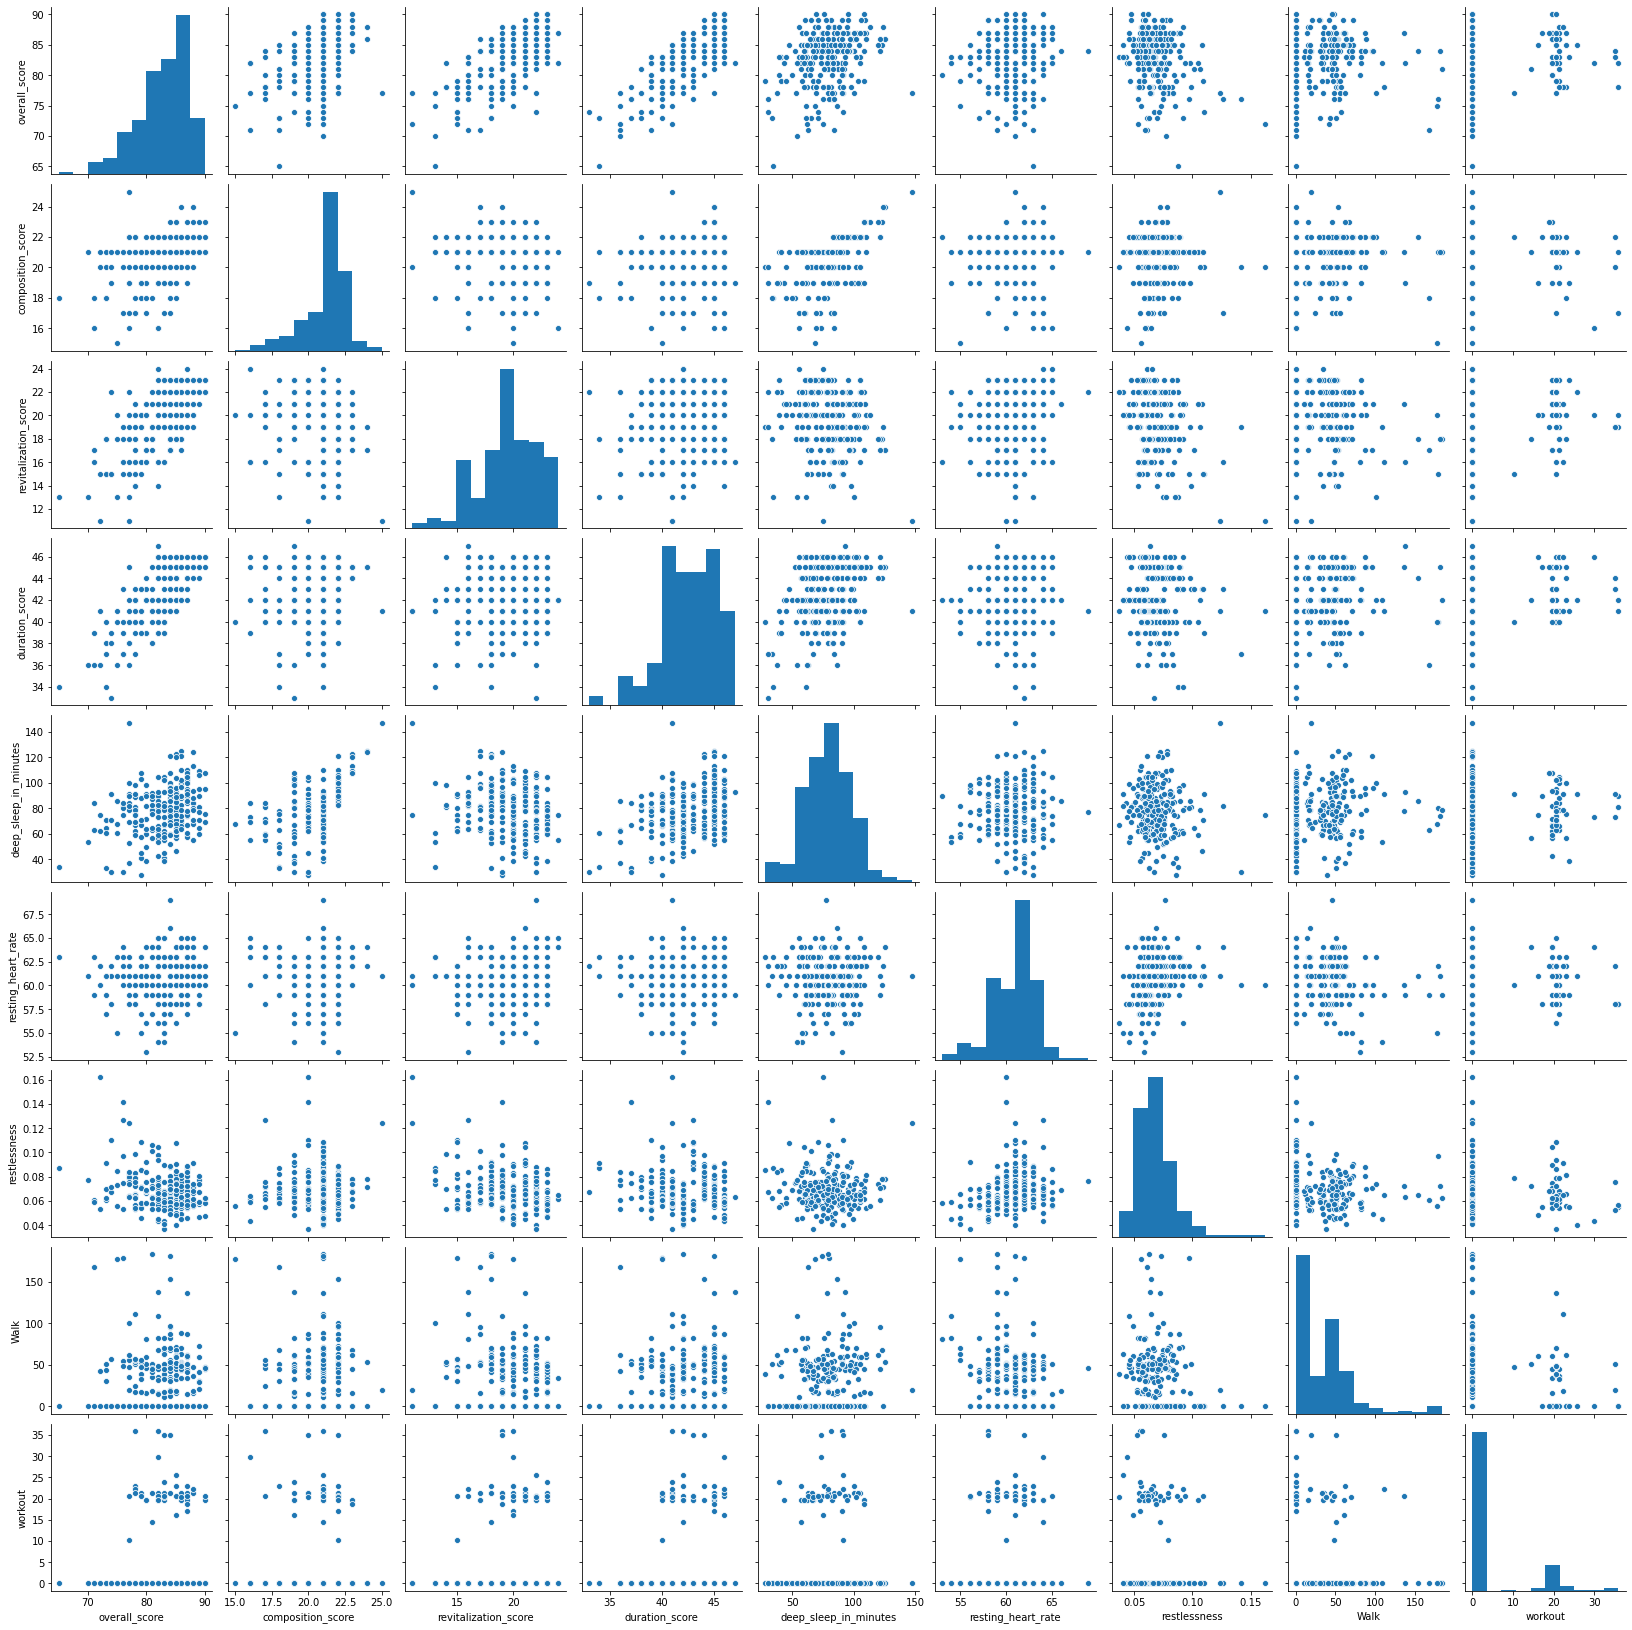

In [68]:
sb.pairplot(all_data) #look for correlations

There seems to be an inverse correlation between % restlessness and RHR. There also may be a correlation with workout time and walk. Let's have a more quantitative look with the Pearson's correlation coefficient

In [119]:
from scipy.stats import pearsonr

corr, _ = pearsonr(all_data.loc[:,'restlessness'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and restlessness: %.3f' % corr)

corr, _ = pearsonr(all_data.loc[:,'Walk'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and walking: %.3f' % corr)

corr, _ = pearsonr(all_data.loc[:,'workout'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and working out: %.3f' % corr)

corr, _ = pearsonr(all_data.loc[:,'overall_score'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and overall sleep score: %.3f' % corr)

corr, _ = pearsonr(all_data.loc[:,'deep_sleep_in_minutes'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and deep sleep min: %.3f' % corr)

corr, _ = pearsonr(all_data.loc[:,'duration_score'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and duration score: %.3f' % corr)

corr, _ = pearsonr(all_data.loc[:,'revitalization_score'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and revitalization score: %.3f' % corr)

corr, _ = pearsonr(all_data.loc[:,'composition_score'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and composition score: %.3f' % corr)

Pearsons correlation RHR and restlessness: 0.225
Pearsons correlation RHR and walking: -0.219
Pearsons correlation RHR and working out: -0.037
Pearsons correlation RHR and overall sleep score: 0.105
Pearsons correlation RHR and deep sleep min: 0.006
Pearsons correlation RHR and duration score: 0.088
Pearsons correlation RHR and revitalization score: 0.073
Pearsons correlation RHR and composition score: 0.019


Percent of sleep that was restless and time walking seem to have the most correlation with RHR. Overall sleep score has the strongest correlation of the "scores."

## First version of linear regression model <a class="anchor" id="third-bullet"></a>

In [120]:
all_data = all_data.reset_index()
np.random.seed(42) 
index_list = list(range(0, len(all_data)))
np.random.shuffle(index_list)
#trainIndex = list(range(0, index_list[round(0.8*len(all_data))])) #training set will be 80% of the dataset
#testIndex = list(range(len(trainIndex), len(trainIndex) + (len(all_data)-len(trainIndex)))) #test set will be the remaining 20%
trainIndex = index_list[0:round(0.8*len(index_list))]
testIndex = index_list[round(0.8*len(index_list))+1:]

#wrote a function that generates the training and test sets and the X and y matrices for each; use this throughout project
def generateXyobjects(data_matrix, trainIndex, testIndex, featureIndex, targetIndex):
    X = data_matrix.iloc[:, featureIndex]
    Xtrain = X.iloc[trainIndex, :]
    Xtrain = Xtrain.to_numpy()
    Xtrain = np.c_[np.ones((Xtrain.shape[0],1)), Xtrain]
    y = data_matrix.iloc[:, targetIndex].to_numpy()
    ytrain = y[trainIndex]
    Xtest = X.iloc[testIndex, :].to_numpy()
    Xtest = np.c_[np.ones((Xtest.shape[0],1)), Xtest]
    yTest = y[testIndex]
    return Xtrain, ytrain, Xtest, yTest

Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [7, 8, 9], 6)

In [129]:
def computeCost(m, yPredict, y):
	sq_error = np.square((yPredict - y))
	J = (1/2/m) * np.sum(sq_error)
	return J

#My first model
theta_best = np.linalg.inv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ytrain) #use normal equation to find theta since have relatively small training set
y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)
Jtrain_linear = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_linear = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be', theta_best, 'with a cost of %.2f (training set) %.2f (test set)' %(Jtrain_linear, Jtest_linear))

#with a cost of %.3f (training set) %.3f (test set) , Jtrain_linear, Jtest_linear)

the normal equation found theta to be [ 5.97612192e+01  2.16436894e+01 -1.21389277e-02 -1.05346038e-02] with a cost of 2.65 (training set) 1.90 (test set)


To figure out if variance or bias is the problem with our model (or a bit of both), we make learning curves.

Bias is a result of the model underfitting the data, and to make a better model we can add polynomial features or add more features. Variance is a result of the model overfitting the data. To recify this, a larger training set could help.

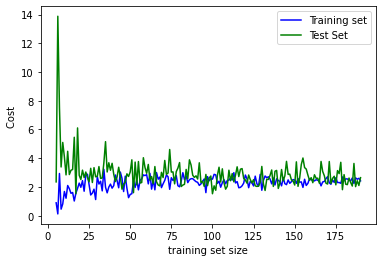

In [95]:
def computeTheta(Xtrain, ytrain):
	theta = np.linalg.pinv(Xtrain.T.dot(Xtrain)).dot(Xtrain.T).dot(ytrain)
	return theta

learning_curve_data = np.array([])
i = list(range(5, round(len(index_list)*0.8)))
np.random.seed(42) 

for a in i:
	np.random.shuffle(index_list)
	all_data_shuffled = all_data.iloc[index_list, -4:]
	all_data_shuffled = all_data_shuffled.reset_index() 
	all_data_shuffled.drop('index', axis = 1, inplace = True)
	Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data_shuffled, list(range(0, a)), list(range(a, (a+len(testIndex)))), [1, 2, 3], 0)
	theta = computeTheta(Xtrain, ytrain)
	yPredictTest = Xtest.dot(theta)
	yPredictTrain = Xtrain.dot(theta)
	Jtrain = computeCost(a, yPredictTrain, ytrain)
	Jtest = computeCost(len(testIndex), yPredictTest, yTest)
	iteration = np.array([a, Jtrain, Jtest], dtype=object)
	learning_curve_data = np.concatenate((learning_curve_data, iteration), axis = 0)

learning_curve_data = np.reshape(learning_curve_data, (-1, 3))  
fig, ax = plt.subplots()
ax.plot(learning_curve_data[:, 0], learning_curve_data[:, 1], 'b-', label = 'Training set')
ax.plot(learning_curve_data[:, 0], learning_curve_data[:, 2], 'g-', label = 'Test Set')
ax.set(xlabel='training set size', ylabel='Cost ')
ax.legend()
plt.show()

After just ~50 training examples (or sooner), the test set cost is lowered to the training set cost. We definitely do not need more training examples to make a better model.

Let's plot the predicted RHR and actual RHR just to visualise how well the model is doing. Here I'm just plotting the test set.

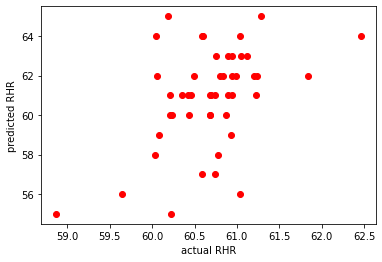

In [96]:
fig, ax = plt.subplots()
ax.plot(yPredictTest, yTest, 'ro')
ax.set(xlabel='actual RHR', ylabel='predicted RHR')
plt.show()

## Improving the model  <a class="anchor" id="fourth-bullet"></a>

But can we do better?

Two ways to make a better model with high bias are:
- Add more features (i.e. overall sleep score)
- Add polynomial features (i.e. restlessness^2, restlessness^3)
- Add interation features (i.e. working out min * walking min)

I will try some variations on these and see if it reduces the cost of the training and test sets.

I am going to start by making restlessness a polynomial feature.

## Polynomial Features <a class="anchor" id="fifth-bullet"></a>

In [131]:
all_data = all_data.iloc[:, -4:]
all_data['restlessness_sqd'] = all_data.loc[:,'restlessness'] ** 2

Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_squared = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_squared = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ' , theta_best, 'with a cost of %.2f (training set) %.2f (test set)' % (Jtrain_squared, Jtest_squared))

the normal equation found theta to be  [ 5.48884260e+01  1.44384290e+02 -1.28626230e-02 -7.80600155e-03
 -7.15561103e+02] with a cost of 2.55 (training set) 1.64 (test set)


In [98]:
all_data['restlessness_cubd'] = all_data.loc[:,'restlessness'] ** 3

Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4, 5], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_cubed = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_cubed = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ', theta_best, 'with a cost of ', Jtrain_cubed, '(training set)', Jtest_cubed, '(test set)')

the normal equation found theta to be  [ 5.32807947e+01  2.03697115e+02 -1.28809140e-02 -7.32202487e-03
 -1.39863899e+03  2.41514119e+03] with a cost of  2.551006467612945 (training set) 1.6124108471509095 (test set)


In [99]:
all_data['restlessness_4th'] = all_data.loc[:,'restlessness'] ** 4

Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4, 5, 6], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_4th = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_4th = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ', theta_best, 'with a cost of ', Jtrain_4th, '(training set)', Jtest_4th, '(test set)')

the normal equation found theta to be  [ 5.33193262e+01  2.01613037e+02 -1.28818774e-02 -7.31979697e-03
 -1.35885354e+03  2.09893195e+03  8.78165290e+02] with a cost of  2.5509850589906398 (training set) 1.612476834362615 (test set)


In [100]:
all_data['restlessness_5th'] = all_data.loc[:,'restlessness'] ** 5

Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4, 5, 6, 7], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_5th = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_5th = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ', theta_best, 'with a cost of ', Jtrain_5th, '(training set)', Jtest_5th, '(test set)')

the normal equation found theta to be  [ 5.33228740e+01  2.01435454e+02 -1.28819855e-02 -7.31963723e-03
 -1.35588619e+03  2.08185668e+03  8.71548358e+02  2.24891747e+02] with a cost of  2.5509828900426776 (training set) 1.6124872881851369 (test set)


Here is a table of the cost of the model on the train and test sets.

| Polynomial power | J$_{train}$ | J$_{test}$ |
| --- | --- | --- |
| 1 | 2.64 | 1.90 |
| 2 | 2.55 | 1.64 |
| 3 | 2.55 | 1.61 |
| 4 | 2.55 | 1.61 |
| 5 | 2.55 | 1.61 |

Adding a squared restlessness and cubed restlessness feature does lower the cost for the test set. I will try adding polynomial features for walking min and see if it lowers the cost further.

In [101]:
all_data.drop(['restlessness_4th', 'restlessness_5th'], axis = 1, inplace = True) #Delete those polynomial features which do not lower cost

In [102]:
all_data['walk_sqd'] = all_data.loc[: , 'Walk'] ** 2  #add squared feature to X
Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4, 5, 6], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_wsqd = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_wsqd = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ' , theta_best, 'with a cost of ', Jtrain_wsqd, '(training set)', Jtest_wsqd, '(test set)')

the normal equation found theta to be  [ 5.49561968e+01  1.39624968e+02 -9.31749002e-03 -7.71949149e-03
 -6.58343775e+02 -1.89794111e+02 -2.72102362e-05] with a cost of  2.550115130632564 (training set) 1.6618185849453924 (test set)


In [103]:
all_data['walk_cubed'] = all_data.loc[: , 'Walk'] ** 3
Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4, 5, 6, 7], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_wcbd = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_wcbd = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ' , theta_best, 'with a cost of ', Jtrain_wcbd, '(training set)', Jtest_wcbd, '(test set)')

the normal equation found theta to be  [ 6.08477880e+01  4.50894184e+00  2.52172689e-02 -1.23149191e-02
  3.59272447e-01  3.13959474e-02 -8.05607780e-04  3.41612307e-06] with a cost of  2.638841705071077 (training set) 2.1061893733472883 (test set)


Adding polynomial features for walking min only increased the cost of the test set, meaning the model wasn't able to generalize to new examples in the test set any better than before (only worse).

| Polynomial power | J$_{train}$ | J$_{test}$ |
| --- | --- | --- |
| 1 | 2.55 | 1.61 |
| 2 | 2.55 | 1.66 |
| 3 | 2.63 | 2.11 |

So we will delete these polynomial features for walking min. Just as a reminder, this is what our features/target tried to this point look like.

In [18]:
all_data.head()

,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubd,walk_sqd,walk_cubed
0,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000,0.000000
1,61,0.062564,34.984033,21.350427,0.003914,0.000245,1223.882565,42816.348040
2,61,0.066184,46.067588,0.000000,0.004380,0.000290,2122.222664,97765.679336
3,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000,0.000000
4,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000,0.000000


In [104]:
#Now let's delete the polynomial features before we move on
all_data.drop(['walk_sqd', 'walk_cubed'], axis = 1, inplace = True)

I will add an interaction (or quadratic) feature for working out and walking. Maybe if I do no exercise at all or a lot of walking and working out on a particular day that will especially affect my resting heart rate. Let's first calculate the Pearson's correlation coefficient to see if there is a correlation.

In [20]:
all_data['walk_workout'] = all_data['Walk'] * all_data['workout']

corr, _ = pearsonr(all_data.loc[:,'walk_workout'], all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and the combined walk/workout feature: %.3f' % corr)

Pearsons correlation RHR and the combined walk/workout feature: -0.045


In [21]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4, 5, 6], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_qdft = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_qdft = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ', theta_best, 'with a cost of ', Jtrain_qdft, '(training set)', Jtest_qdft, '(test set)')

the normal equation found theta to be  [ 5.26988269e+01  2.24059226e+02 -6.42777606e-03 -7.74884920e-03
 -1.73176735e+03  3.97790035e+03 -1.99574074e-05] with a cost of  1.6798512004542427 (training set) 5.207177565933401 (test set)


This does not decrease the cost of the test set. How about the interaction between % time restless sleep and minutes walking? These two features have the highest Pearson's correlation coefficient with resting heart rate. 

In [22]:
all_data['restless_walk'] = all_data['Walk'] * all_data['restlessness']  #Add new interation feature between restlessness and walk time
all_data.drop('walk_workout', axis = 1, inplace = True) #Drop previous interaction feature
all_data.head()

,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubd,restless_walk
0,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000
1,61,0.062564,34.984033,21.350427,0.003914,0.000245,2.188745
2,61,0.066184,46.067588,0.000000,0.004380,0.000290,3.048941
3,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000
4,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000


In [23]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [1, 2, 3, 4, 5, 6], 0)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_qdft_rw = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_qdft_rw = computeCost(len(testIndex), y_predict_test, yTest)

print('the normal equation found theta to be ', theta_best, 'with a cost of ', Jtrain_qdft_rw, '(training set)', Jtest_qdft_rw, '(test set)')

the normal equation found theta to be  [ 5.35489262e+01  2.08063223e+02 -2.53052579e-02 -8.94383122e-03
 -1.68513685e+03  4.11122768e+03  2.65432573e-01] with a cost of  1.672277655267991 (training set) 5.018616386057134 (test set)


This does lower the cost of the test set! Let's keep this interaction variable between % restlessness of sleep time and walking time in min

How about adding more, new features? Lets add in the overall sleep score, which had a Pearson's correlation coefficient of ~0.1 with resting heart rate. We will square time percentage of time restless since this was shown to lower the cost of the test set.

In [24]:
all_data = sleep_rhr_data.join(exercise_data_df, how = 'left') #Start with data we began with and drop features we aren't interested in
all_data = all_data.fillna(0)
all_data.drop(['composition_score', 'revitalization_score', 'duration_score', 'deep_sleep_in_minutes'], axis = 1, inplace = True)
all_data['restlessness_sqd'] = all_data.loc[:,'restlessness'] ** 2
all_data['restlessness_cubed'] = all_data.loc[:,'restlessness'] ** 3
all_data['restless_walk'] = all_data['Walk'] * all_data['restlessness']  #Add new interation feature between restlessness and walk time
all_data.head()

,overall_score,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubed,restless_walk
timestamp,,,,,,,,
2021-01-20,79,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000
2021-01-19,81,61,0.062564,34.984033,21.350427,0.003914,0.000245,2.188745
2021-01-18,80,61,0.066184,46.067588,0.000000,0.004380,0.000290,3.048941
2021-01-17,87,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000
2021-01-16,82,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000


In [25]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [0, 2, 3, 4, 5, 6, 7], 1)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_addFeat = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_addFeat = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_addFeat, 'and for the test set',Jtest_addFeat)

The cost for the training set is 1.6421013245596585 and for the test set 4.890097772919588


This did slightly decrease the cost of the test set. This means that it does help the model be slightly more accurate. 

Let's add more features that correlate with RHR (see Pearson's correlation coefficients above). I will add revitalization, composition, and duration scores which have somewhat of a correlation.

## Adding more features <a class="anchor" id="sixth-bullet"></a>

In [26]:
all_data = sleep_rhr_data.join(exercise_data_df, how = 'left') #Start with data we began with and drop features we aren't interested in
all_data = all_data.fillna(0)
all_data.drop(['deep_sleep_in_minutes'], axis = 1, inplace = True)
all_data['restlessness_sqd'] = all_data.loc[:,'restlessness'] ** 2
all_data['restlessness_cubed'] = all_data.loc[:,'restlessness'] ** 3
all_data['restless_walk'] = all_data['Walk'] * all_data['restlessness']
all_data.head()

,overall_score,composition_score,revitalization_score,duration_score,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubed,restless_walk
timestamp,,,,,,,,,,,
2021-01-20,79,20,16,43,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000
2021-01-19,81,21,19,41,61,0.062564,34.984033,21.350427,0.003914,0.000245,2.188745
2021-01-18,80,17,21,42,61,0.066184,46.067588,0.000000,0.004380,0.000290,3.048941
2021-01-17,87,20,22,45,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000
2021-01-16,82,16,24,42,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000


In [27]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data, trainIndex, testIndex, [0, 1, 2, 3, 5, 6, 7, 8, 9, 10], 4)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_addFeatmore = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_addFeatmore = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_addFeatmore, 'and for the test set', Jtest_addFeatmore)

The cost for the training set is 1.6348364150337562 and for the test set 4.8732809489447


Adding in these extra features doesn't help much! The cost is roughly the same. This is probably because these features do not bring in much more predictive information than we already have. 

Let's do one last learning curve.

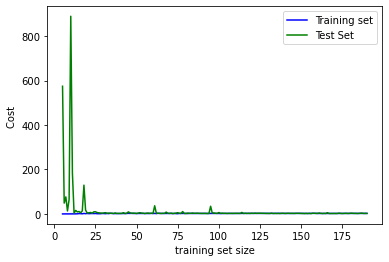

In [28]:
learning_curve_data = np.array([])
i = list(range(5, round(len(index_list)*0.8)))

for a in i:
	np.random.shuffle(index_list)
	all_data_shuffled = all_data.iloc[index_list, :]
	all_data_shuffled = all_data_shuffled.reset_index() 
	all_data_shuffled.drop('timestamp', axis = 1, inplace = True)
	Xtrain, ytrain, Xtest, yTest = generateXyobjects(all_data_shuffled, list(range(0, a)), list(range(a, (a+len(testIndex)))), [0, 1, 2, 3, 5, 6, 7, 8, 9, 10], 4)
	theta = computeTheta(Xtrain, ytrain)
	yPredictTest = Xtest.dot(theta)
	yPredictTrain = Xtrain.dot(theta)
	Jtrain = computeCost(a, yPredictTrain, ytrain)
	Jtest = computeCost(len(testIndex), yPredictTest, yTest)
	iteration = np.array([a, Jtrain, Jtest], dtype=object)
	learning_curve_data = np.concatenate((learning_curve_data, iteration), axis = 0)

learning_curve_data = np.reshape(learning_curve_data, (-1, 3))  
fig, ax = plt.subplots()
ax.plot(learning_curve_data[:, 0], learning_curve_data[:, 1], 'b-', label = 'Training set')
ax.plot(learning_curve_data[:, 0], learning_curve_data[:, 2], 'g-', label = 'Test Set')
ax.set(xlabel='training set size', ylabel='Cost ')
ax.legend()
plt.show()

Even with the extra features, our model still has high bias. Adding in more features means that the model needs more training examples for the cost of the training set to meet the test set (now needs maybe 75?).

We've done a few things to improve model performance by this point. Let's review:
- Added polynomial features (we squared and cubed the restlessness and walking features, polynomial features for restlessness help)
- Added interaction or quadratic features (we tried walking * working out-- did not work and restlessness * walking-- did work!)
- Added new features (we added many but overall sleep score was best at reducing cost)

The only way to improve model performance from here is to include more features that help predict resting heart rate. Good thing, Fitbit has even more data on me! In particular, related to exercise. Seeing as time spent walking is more strongly related to RHR than other features, this could help. Let's look at adding the following:
- very active minutes
- moderately active minutes
- lightly active minutes
- sedentary minutes
- total steps

In [29]:
very_active_data = pd.DataFrame() 
for very_active_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/very_active_minutes*')):
   df = pd.read_json(very_active_file, dtype = True)
   very_active_data = very_active_data.append(df) 

very_active_data = very_active_data.set_index('dateTime')
very_active_data.columns = ['very_ac_time']

In [30]:
moderately_active_data = pd.DataFrame() 
for moderately_active_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/moderately_active_minutes*')):
   df = pd.read_json(moderately_active_file, dtype = True)
   moderately_active_data = moderately_active_data.append(df) 

moderately_active_data = moderately_active_data.set_index('dateTime')
moderately_active_data.columns = ['mod_ac_time']

In [31]:
lightly_active_data = pd.DataFrame() 
for lightly_active_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/lightly_active_minutes*')):
   df = pd.read_json(lightly_active_file, dtype = True)
   lightly_active_data = lightly_active_data.append(df) 

lightly_active_data = lightly_active_data.set_index('dateTime')
lightly_active_data.columns = ['light_ac_time']

In [32]:
sedentary_data = pd.DataFrame() 
for sedentary_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/sedentary_minutes*')):
   df = pd.read_json(sedentary_file, dtype = True)
   sedentary_data = sedentary_data.append(df) 

sedentary_data = sedentary_data.set_index('dateTime')
sedentary_data.columns = ['sed_time']

In [33]:
steps_data = pd.DataFrame() 
for steps_file in glob.glob(os.path.join(os.getcwd(), 'LaurenFleming_original_data/Physical_Activity/steps*')):
   df = pd.read_json(steps_file, dtype = True)
   steps_data = steps_data.append(df) 

steps_data['date'] = steps_data['dateTime'].dt.date

In [35]:
steps_data_df = pd.pivot_table(steps_data, values = 'value', index = 'date', aggfunc = np.sum)
steps_data_df.columns = ['step_count']
steps_data_df.head()

,step_count
date,
2019-02-21,5003
2019-02-22,6027
2019-02-23,5235
2019-02-24,5540
2019-02-25,7545


In [36]:
all_data.head()

,overall_score,composition_score,revitalization_score,duration_score,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubed,restless_walk
timestamp,,,,,,,,,,,
2021-01-20,79,20,16,43,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000
2021-01-19,81,21,19,41,61,0.062564,34.984033,21.350427,0.003914,0.000245,2.188745
2021-01-18,80,17,21,42,61,0.066184,46.067588,0.000000,0.004380,0.000290,3.048941
2021-01-17,87,20,22,45,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000
2021-01-16,82,16,24,42,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000


In [37]:
morefeatures_all_data = pd.concat([all_data, sedentary_data, lightly_active_data, moderately_active_data, very_active_data, steps_data_df], axis = 1, join = 'inner')
morefeatures_all_data.head()

,overall_score,composition_score,revitalization_score,duration_score,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubed,restless_walk,sed_time,light_ac_time,mod_ac_time,very_ac_time,step_count
2021-01-20,79,20,16,43,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000,61,26,0,0,772
2021-01-19,81,21,19,41,61,0.062564,34.984033,21.350427,0.003914,0.000245,2.188745,674,207,28,29,10995
2021-01-18,80,17,21,42,61,0.066184,46.067588,0.000000,0.004380,0.000290,3.048941,649,257,10,41,12550
2021-01-17,87,20,22,45,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000,632,210,11,0,4930
2021-01-16,82,16,24,42,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000,798,155,0,0,2420


In [38]:
corr, _ = pearsonr(morefeatures_all_data.loc[:,'sed_time'], morefeatures_all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and sedentary time: %.3f' % corr)

corr, _ = pearsonr(morefeatures_all_data.loc[:,'step_count'], morefeatures_all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and step count: %.3f' % corr)

active_min = morefeatures_all_data.loc[:,'very_ac_time'] + morefeatures_all_data.loc[:,'light_ac_time'] + morefeatures_all_data.loc[:,'mod_ac_time']

corr, _ = pearsonr(active_min, morefeatures_all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and active minutes: %.3f' % corr)

Pearsons correlation RHR and sedentary time: 0.123
Pearsons correlation RHR and step count: -0.276
Pearsons correlation RHR and active minutes: -0.258


Daily sedentary minutes, daily step count, and daily active minutes all have correlations with resting heart rate! The latter two are even stronger than sedentary time. Let's see if very active time, light active time, and moderately active time have stronger individual correlations than summed together as active minutes.

In [39]:
corr, _ = pearsonr(morefeatures_all_data.loc[:,'light_ac_time'], morefeatures_all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and lightly active min: %.3f' % corr)

corr, _ = pearsonr(morefeatures_all_data.loc[:,'mod_ac_time'], morefeatures_all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and moderately active min: %.3f' % corr)

corr, _ = pearsonr(morefeatures_all_data.loc[:,'very_ac_time'], morefeatures_all_data.loc[:,'resting_heart_rate'])
print('Pearsons correlation RHR and very active min: %.3f' % corr)

Pearsons correlation RHR and lightly active min: -0.198
Pearsons correlation RHR and moderately active min: -0.198
Pearsons correlation RHR and very active min: -0.191


They actually have a stronger correlation when summed together. This suggests that any level of activity may lower your resting heart rate.

I will combine (sum) these features in an active minutes column and get rid of the individual features

In [40]:
morefeatures_all_data['active_min']= morefeatures_all_data.loc[:,'very_ac_time'] + morefeatures_all_data.loc[:,'light_ac_time'] + morefeatures_all_data.loc[:,'mod_ac_time']
morefeatures_all_data.drop(['very_ac_time', 'light_ac_time', 'mod_ac_time', 'composition_score', 'revitalization_score', 'duration_score'], axis = 1, inplace = True)
morefeatures_all_data.head()

,overall_score,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubed,restless_walk,sed_time,step_count,active_min
2021-01-20,79,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000,61,772,26
2021-01-19,81,61,0.062564,34.984033,21.350427,0.003914,0.000245,2.188745,674,10995,264
2021-01-18,80,61,0.066184,46.067588,0.000000,0.004380,0.000290,3.048941,649,12550,308
2021-01-17,87,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000,632,4930,221
2021-01-16,82,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000,798,2420,155


I will now add these features one by one to see how they lower the cost. I'll start with step count since this has the highest correlation

In [41]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(morefeatures_all_data, trainIndex, testIndex, [0, 2, 3, 4, 5, 6, 7, 9], 1)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_addStep = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_addStep = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_addStep, 'and for the test set', Jtest_addStep)

The cost for the training set is 1.6146724081726849 and for the test set 4.903485785812638


In [42]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(morefeatures_all_data, trainIndex, testIndex, [0, 2, 3, 4, 5, 6, 7, 10], 1)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_addAcMin = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_addAcMin = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_addAcMin, 'and for the test set', Jtest_addAcMin)

The cost for the training set is 1.6229587607664535 and for the test set 4.765544511649269


In [43]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(morefeatures_all_data, trainIndex, testIndex, [0, 2, 4, 3, 5, 6, 7, 8], 1)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_addSed = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_addSed = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_addSed, 'and for the test set', Jtest_addSed)

The cost for the training set is 1.623073854648709 and for the test set 4.816899882765748


In [44]:
Xtrain, ytrain, Xtest, yTest = generateXyobjects(morefeatures_all_data, trainIndex, testIndex, [0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 1)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_addAll = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_addAll = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_addAll, 'and for the test set', Jtest_addAll)

The cost for the training set is 1.6051771564529336 and for the test set 4.941219436748548


To summarise, here are the costs when we add these new features in.

| New Feature | J$_{train}$ | J$_{test}$ |
| --- | --- | --- |
| begin with | 1.64 | 4.89 |
| step count | 1.61 | 4.90 |
| active minutes | 1.62 | 4.77 |
| sedentary minutes | 1.62 | 4.82 |
| all together | 1.61 | 4.94 |

Despite having the higher correlation with RHR, step count did not lower the cost of the training set. However, adding in active minutes did lower the cost of the test set so let's keep it in. 

In [45]:
morefeatures_all_data.drop(['step_count', 'sed_time'], axis = 1 , inplace = True)

Will adding polynomial features for active minutes help the model generalise better to the test set? Let's try.

In [55]:
morefeatures_all_data['active_min_sqd'] = morefeatures_all_data.loc[:, 'active_min'] ** 2

Xtrain, ytrain, Xtest, yTest = generateXyobjects(morefeatures_all_data, trainIndex, testIndex, [0, 2, 3, 4, 5, 6, 7, 8, 9], 1)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_AcMinSq = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_AcMinSq = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_AcMinSq, 'and for the test set', Jtest_AcMinSq)

The cost for the training set is 1.6553325662845328 and for the test set 4.887261353896365


In [50]:
morefeatures_all_data['active_min_cub'] = morefeatures_all_data.loc[:, 'active_min'] ** 3

Xtrain, ytrain, Xtest, yTest = generateXyobjects(morefeatures_all_data, trainIndex, testIndex, [0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 1)

theta_best = computeTheta(Xtrain, ytrain)

y_predict_train = Xtrain.dot(theta_best)
y_predict_test = Xtest.dot(theta_best)

#compute cost
Jtrain_AcMinCub = computeCost(len(trainIndex), y_predict_train, ytrain)
Jtest_AcMinCub = computeCost(len(testIndex), y_predict_test, yTest)

print('The cost for the training set is', Jtrain_AcMinCub, 'and for the test set', Jtest_AcMinCub)

The cost for the training set is 5.0153710719732 and for the test set 9.683498182553883


In [51]:
morefeatures_all_data.head()

,overall_score,resting_heart_rate,restlessness,Walk,workout,restlessness_sqd,restlessness_cubed,restless_walk,active_min,active_min_sqd,active_min_cub
2021-01-20,79,60,0.056877,0.000000,0.000000,0.003235,0.000184,0.000000,26,676,17576
2021-01-19,81,61,0.062564,34.984033,21.350427,0.003914,0.000245,2.188745,264,69696,18399744
2021-01-18,80,61,0.066184,46.067588,0.000000,0.004380,0.000290,3.048941,308,94864,29218112
2021-01-17,87,63,0.069787,0.000000,0.000000,0.004870,0.000340,0.000000,221,48841,10793861
2021-01-16,82,65,0.061224,0.000000,0.000000,0.003748,0.000229,0.000000,155,24025,3723875


These polynomial features did not help. Just as a recap:

| polynomial power (active min) | J$_{train}$ | J$_{test}$ |
| --- | --- | --- |
| 1 | 1.62 | 4.77 |
| 2 | 1.66 | 4.88 |
| 3 | 5.01 | 9.68 |

Let's get rid of these polynomial features, as they only increase the cost for the train and test sets.

## Summary <a class="anchor" id="seventh-bullet"></a>